In [11]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [12]:
# Определить устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### 1. Скачать тренировочный и тестовый наборы данных Fashion MNIST из библиотеки torchvision

In [13]:
# Преобразователь данных
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Загрузка данных
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Разделить тренировочный датасет на 80% данных для обучения и 20% для валидации
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Загрузчик данных
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_subset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [14]:
# Для просмотра данных
def show_data(dataset, n_images=10):
    labels = dataset.classes

    random_indices = np.random.choice(len(dataset), n_images, replace=False)
    fig, axes = plt.subplots(1, n_images, figsize=(15, 3))

    for i, idx in enumerate(random_indices):
        image, label = dataset[idx]
        image = image.squeeze()

        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(labels[label])
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

Тренировочный датасет:



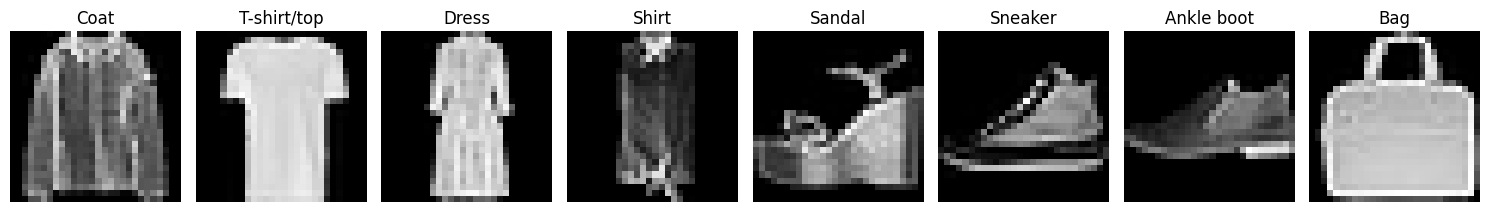

Тестовый датасет:



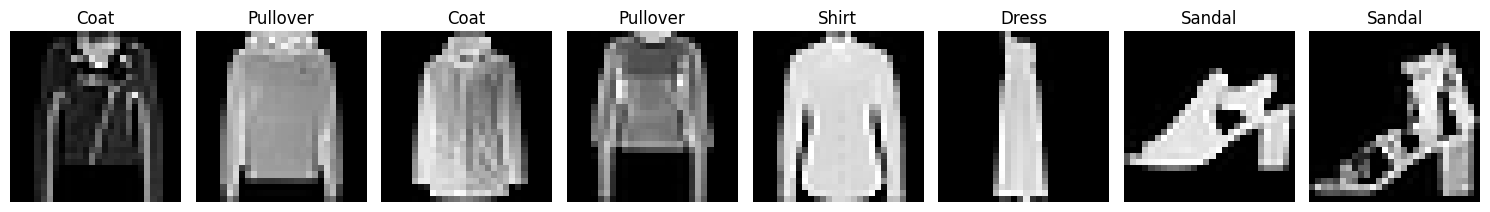

In [15]:
print("Тренировочный датасет:\n")
show_data(train_dataset, 8)

print("Тестовый датасет:\n")
show_data(test_dataset, 8)

### 2. Построить архитектуру нейронной сети
Она должна включать следующие элементы:
* Свёрточные слои;
* Слои регуляризации;
* Один финальный полносвязный слой.

In [16]:
class FashionMnistModel(nn.Module):
    def __init__(self):
        super(FashionMnistModel, self).__init__()

        # cвёрточные слои
        self.conv_1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn_1 = nn.BatchNorm2d(32)
        self.conv_2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn_2 = nn.BatchNorm2d(64)
        self.conv_3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn_3 = nn.BatchNorm2d(128)

        # пулинговые слои
        self.pool_1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # полносвязный слой
        self.fc_1 = nn.Linear(128 * 3 * 3, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc_2 = nn.Linear(512, 10)

    def forward(self, x):
        # прямой проход
        x = self.pool_1(F.relu(self.bn_1(self.conv_1(x))))
        x = self.pool_1(F.relu(self.bn_2(self.conv_2(x))))
        x = self.pool_1(F.relu(self.bn_3(self.conv_3(x))))

        # преобразование тензора в вектор
        x = x.view(-1, 128 * 3 * 3)

        x = F.relu(self.fc_1(x))
        x = self.dropout(x)
        x = self.fc_2(x)

        return x

In [17]:
# Создать модель
model = FashionMnistModel()
model.to(device)

FashionMnistModel(
  (conv_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_1): Linear(in_features=1152, out_features=512, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_2): Linear(in_features=512, out_features=10, bias=True)
)

### 3. Настроить оптимизатор и выбрать функцию потерь

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### 4. Обучить модель

In [21]:
def train(model, train_loader, val_loader, criterion, optimizer, n_epochs=5):
    best_accuracy = 0.0

    for epoch in range(n_epochs):
        cur_loss = 0.0
        correct = 0
        all = 0

        model.train()

        # обучение
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            cur_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            all += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / all
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {cur_loss/len(train_loader):.3f}, Train accuracy: {train_accuracy:.3f}%')

        # тестирование
        correct = 0
        all = 0

        model.eval()

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                all += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / all
        print(f'Val Accuracy: {val_accuracy:.3f}%')

        # сохранить модель
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), 'fashionMnist_model.pth')

In [22]:
train(model, train_loader, val_loader, criterion, optimizer)

Epoch [1/5], Loss: 0.201, Train accuracy: 92.569%
Val Accuracy: 91.650%
Epoch [2/5], Loss: 0.176, Train accuracy: 93.475%
Val Accuracy: 92.075%
Epoch [3/5], Loss: 0.158, Train accuracy: 94.246%
Val Accuracy: 92.100%
Epoch [4/5], Loss: 0.139, Train accuracy: 94.858%
Val Accuracy: 92.492%
Epoch [5/5], Loss: 0.124, Train accuracy: 95.350%
Val Accuracy: 91.675%


### 5. Загрузить модель и посмотреть предсказания

In [25]:
def show_predictions(model, dataset, n_images=10):
    model.eval()

    labels = dataset.classes

    random_indices = np.random.choice(len(dataset), n_images, replace=False)

    fig, axes = plt.subplots(1, n_images, figsize=(15, 3))

    with torch.no_grad():
        for i, idx in enumerate(random_indices):
            image, true_label = dataset[idx]

            # добавить размерность батча и перенести на устройство
            image = image.unsqueeze(0).to(device)

            # предсказание
            outputs = model(image)
            _, predicted_label = torch.max(outputs, 1)
            predicted_label = predicted_label.item()

            # возвратить картинку к исходному формату
            image = image.squeeze().cpu().numpy()

            axes[i].imshow(image, cmap='gray')
            axes[i].set_title(f"{labels[true_label]} \ {labels[predicted_label]}")
            axes[i].axis('off')

    plt.tight_layout()
    plt.show()

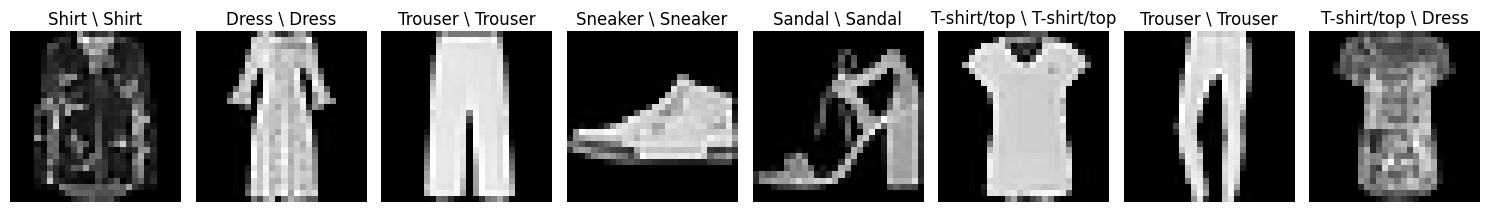

In [27]:
model.load_state_dict(torch.load('fashionMnist_model.pth'))
model.to(device)

show_predictions(model, test_dataset, 8)